## Import libraries

https://medium.com/@crisvelasquez/stock-scenario-modelling-tail-risk-dependence-with-copulas-in-python-25591885366f

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer
from scipy.stats import norm
import matplotlib.pyplot as plt
from copulae import GaussianCopula
import requests 

import warnings; warnings.filterwarnings("ignore")

## load data

In [18]:
portfolio_tickers = ["MSFT", "AAPL", "GOOGL"]

end_date = "2022-01-01"
start_date = "2020-01-01"

symbols = ["^GSPC"] + portfolio_tickers

data = yf.download(symbols, start=start_date, end=end_date)["Close"]

[*********************100%***********************]  4 of 4 completed


In [19]:
data

Ticker,AAPL,GOOGL,MSFT,^GSPC
Date,,,,
2020-01-02,72.620850,68.026024,153.042313,3257.850098
2020-01-03,71.914818,67.670151,151.136673,3234.850098
2020-01-06,72.487846,69.473846,151.527283,3246.280029
2020-01-07,72.146935,69.339645,150.145691,3237.179932
2020-01-08,73.307510,69.833183,152.537323,3253.050049
...,...,...,...,...
2021-12-27,176.996689,147.024719,332.514648,4791.189941
2021-12-28,175.975937,145.812531,331.349457,4786.350098
2021-12-29,176.064301,145.780685,332.029236,4793.060059


## Steps

In [20]:
market_drop_percentage = -0.05

In [22]:
returns = data.pct_change().dropna()
returns

Ticker,AAPL,GOOGL,MSFT,^GSPC
Date,,,,
2020-01-03,-0.009722,-0.005231,-0.012452,-0.007060
2020-01-06,0.007968,0.026654,0.002584,0.003533
2020-01-07,-0.004703,-0.001932,-0.009118,-0.002803
2020-01-08,0.016086,0.007118,0.015929,0.004902
2020-01-09,0.021241,0.010498,0.012493,0.006655
...,...,...,...,...
2021-12-27,0.022975,0.006738,0.023186,0.013839
2021-12-28,-0.005767,-0.008245,-0.003504,-0.001010
2021-12-29,0.000502,-0.000218,0.002052,0.001402


In [28]:
quantile_transformers = {}
data_uniform = pd.DataFrame()

for symbol in returns.columns:
    qt = QuantileTransformer(output_distribution='uniform')
    data_uniform[symbol] = qt.fit_transform(returns[[symbol]]).flatten()
    quantile_transformers[symbol] = qt

In [29]:
quantile_transformers

{'AAPL': QuantileTransformer(),
 'GOOGL': QuantileTransformer(),
 'MSFT': QuantileTransformer(),
 '^GSPC': QuantileTransformer()}

In [27]:
def conditional_sample(ul, rho, n_samples = 1000):
    u2 = np.linspace(0.001, 0.999, n_samples)
    return u2, norm.cdf((norm.ppf(ul)-rho * norm.ppf(u2)) / np.sqrt(1-rho**2))

In [33]:
results = {}
for ticker in portfolio_tickers:
    index_drop = quantile_transformers["^GSPC"].transform(np.array([[market_drop_percentage]]))[0][0]

    #bivariate assumption with ^GSPC and each stock
    bi_data = data_uniform[["^GSPC", ticker]]
    bi_copula = GaussianCopula(dim = 2)
    bi_copula.fit(bi_data.values)
    rho = bi_copula.params[0]

    conditional_u2, conditional_cdf = conditional_sample(index_drop, rho)
    conditional_returns = quantile_transformers[ticker].inverse_transform(conditional_cdf.reshape(-1, 1)).flatten()
    results[ticker] = conditional_returns

In [36]:
# Compute portfolio returns from individual stock returns
portfolio_returns = np.mean(np.array([results[ticker] for ticker in portfolio_tickers]), axis=0)

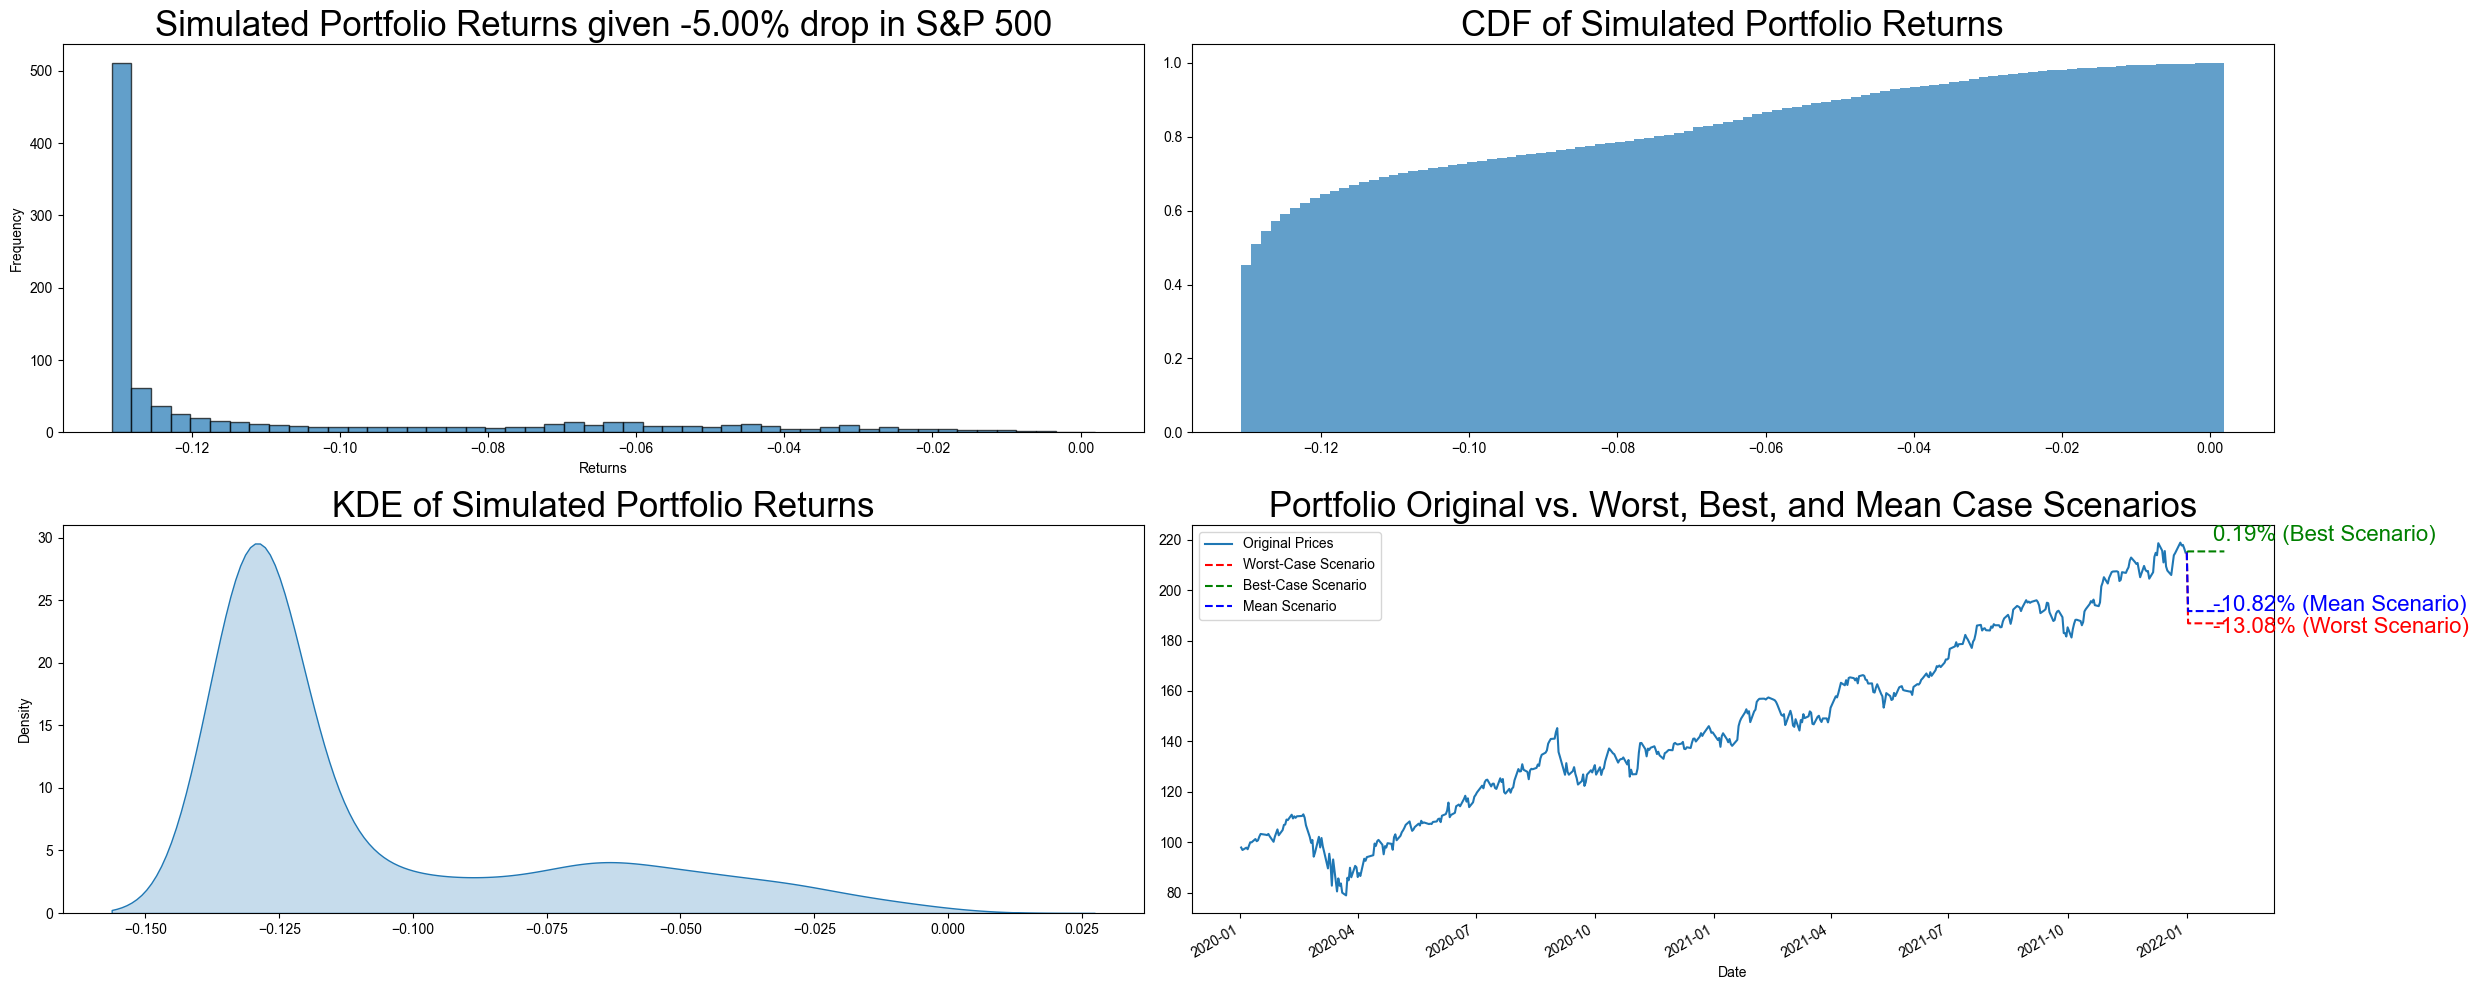

In [38]:
# Visualization for the Portfolio
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
last_known_prices = data[portfolio_tickers].iloc[-1]
portfolio_last_known_price = np.mean(last_known_prices)  # Equally weighted

min_return = np.min(portfolio_returns)
max_return = np.max(portfolio_returns)
mean_return = np.mean(portfolio_returns)

final_min_price = portfolio_last_known_price * (1 + min_return)
final_max_price = portfolio_last_known_price * (1 + max_return)
final_mean_price = portfolio_last_known_price * (1 + mean_return)

simulated_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]

min_price_trajectory = [portfolio_last_known_price] + [final_min_price] * (len(simulated_dates) - 1)
max_price_trajectory = [portfolio_last_known_price] + [final_max_price] * (len(simulated_dates) - 1)
mean_price_trajectory = [portfolio_last_known_price] + [final_mean_price] * (len(simulated_dates) - 1)

# Plot 1: Histogram of Simulated Returns
ax[0, 0].hist(portfolio_returns, bins=50, edgecolor='k', alpha=0.7)
ax[0, 0].set_title(f"Simulated Portfolio Returns given {market_drop_percentage*100:.2f}% drop in S&P 500", fontsize=25)
ax[0, 0].set_xlabel("Returns")
ax[0, 0].set_ylabel("Frequency")

# Plot 2: CDF of Simulated Returns
ax[0, 1].hist(portfolio_returns, bins=100, density=True, cumulative=True, alpha=0.7)
ax[0, 1].set_title('CDF of Simulated Portfolio Returns', fontsize=25)

# Plot 3: KDE of Simulated Returns
sns.kdeplot(portfolio_returns, shade=True, ax=ax[1, 0])
ax[1, 0].set_title('KDE of Simulated Portfolio Returns', fontsize=25)

# Plot 4: Portfolio Original vs. Worst, Best, and Mean Case Scenarios
portfolio_prices = data[portfolio_tickers].mean(axis=1)
portfolio_prices.plot(ax=ax[1, 1], label="Original Prices")
pd.Series(min_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Worst-Case Scenario", linestyle='--', color="red")
pd.Series(max_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Best-Case Scenario", linestyle='--', color="green")
pd.Series(mean_price_trajectory, index=simulated_dates).plot(ax=ax[1, 1], label="Mean Scenario", linestyle='--', color="blue")

label_x_position = simulated_dates[-10]
ax[1, 1].annotate(f"{min_return*100:.2f}% (Worst Scenario)", (label_x_position, final_min_price * 0.98), fontsize=16, ha="left", color="red")
ax[1, 1].annotate(f"{max_return*100:.2f}% (Best Scenario)", (label_x_position, final_max_price * 1.02), fontsize=16, ha="left", color="green")
ax[1, 1].annotate(f"{mean_return*100:.2f}% (Mean Scenario)", (label_x_position, final_mean_price), fontsize=16, ha="left", color="blue")

ax[1, 1].set_title(f"Portfolio Original vs. Worst, Best, and Mean Case Scenarios", fontsize=25)
ax[1, 1].legend()

# General configurations for the plot aesthetics
sns.set_style("whitegrid")
plt.tight_layout()
plt.show()